<a href="https://colab.research.google.com/github/davoodwadi/davoodwadi.github.io/blob/main/Minibatch_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/davoodwadi/davoodwadi.github.io.git"

Cloning into 'davoodwadi.github.io'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 805 (delta 31), reused 42 (delta 17), pack-reused 736
Receiving objects: 100% (805/805), 89.88 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (459/459), done.
Updating files: 100% (244/244), done.


In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor, nn

In [3]:
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

# MNIST dataset

In [4]:
path_data = Path('./davoodwadi.github.io/data/')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
x_train.shape

torch.Size([50000, 784])

In [6]:
y_train[0]

tensor(5)

Text(0.5, 1.0, '5')

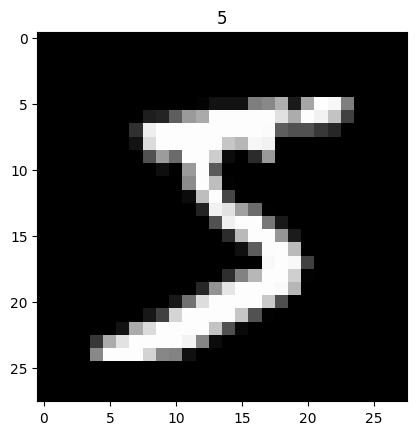

In [7]:
i=0
plt.imshow(x_train[i].view(28,28))
plt.title(y_train[i].item())

# Datasets and dataloaders

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [10]:
train_dataset = dataset(x_train, y_train)
valid_dataset = dataset(x_valid, y_valid)

In [11]:
x, y = train_dataset[0]

In [12]:
x.shape, y.shape

(torch.Size([784]), torch.Size([]))

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [14]:
steps_per_epoch = len(train_loader)
print(f'There are {steps_per_epoch} steps per epoch')
for i, (xs, ys) in enumerate(train_loader):
  if i>(steps_per_epoch-5):
    print(xs.shape)

There are 782 steps per epoch
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([16, 784])


## Define the model

In [15]:
class FCModel(nn.Module):
  def __init__(self, feature_size, hidden_size):
    super(FCModel, self).__init__()

    self.fc1 = nn.Linear(feature_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 10)
    self.relu = nn.ReLU()
  def forward(self, x):
    out1 = self.fc1(x)
    out2 = self.relu(out1)
    out3 = self.fc2(out2)
    return out3

# Training loop

In [16]:
hidden_size = 256
lr = 0.01

model = FCModel(x_train.shape[1], hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()

In [17]:
epoch = 10
for e in range(epoch):
  correct = 0
  total = 0
  losses = []

  # training
  model.train()
  for bx, by in train_loader:
    output = model(bx)
    loss = loss_fn(output, by)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # validation
  model.eval()
  for bx, by in valid_loader:
    with torch.no_grad():
      output = model(bx)
    predictions = output.argmax(-1)

    correct += (predictions==by).float().sum()
    total += len(by)
    losses.append(loss.detach().item())

  accuracy = correct/total
  print(f'epoch {e}; loss {np.mean(losses):.4f}; accuracy {accuracy:.2f}')

epoch 0; loss 0.7945; accuracy 0.86
epoch 1; loss 0.4280; accuracy 0.89
epoch 2; loss 0.3679; accuracy 0.90
epoch 3; loss 0.3218; accuracy 0.91
epoch 4; loss 0.6549; accuracy 0.91
epoch 5; loss 0.3248; accuracy 0.92
epoch 6; loss 0.1839; accuracy 0.92
epoch 7; loss 0.1435; accuracy 0.92
epoch 8; loss 0.1725; accuracy 0.93
epoch 9; loss 0.1761; accuracy 0.93


In [18]:
def train_eval(model, optimizer, train_loader, valid_loader, epoch=10):
  for e in range(epoch):
    correct = 0
    total = 0
    losses = []

    # training
    model.train()
    for bx, by in train_loader:
      output = model(bx)
      loss = loss_fn(output, by)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation
    model.eval()
    for bx, by in valid_loader:
      with torch.no_grad():
        output = model(bx)
      predictions = output.argmax(-1)

      correct += (predictions==by).float().sum()
      total += len(by)
      losses.append(loss.detach().item())

    accuracy = correct/total
    print(f'epoch {e}; loss {np.mean(losses):.4f}; accuracy {accuracy:.2f}')

logits vs. probabilities

In [19]:
bx, by = next(iter(train_loader))
with torch.no_grad():
  output = model(bx)

In [20]:
output

tensor([[    -3.45,     -6.67,      0.36,     -2.68,      2.19,      3.02,      0.43,     -2.21,      5.08,      2.86],
        [    -4.28,      6.55,      1.62,      0.62,     -3.42,     -0.76,     -0.18,     -0.83,      1.54,     -1.82],
        [    -2.26,      0.37,      2.06,      6.46,     -3.64,     -0.41,     -4.73,     -0.73,      1.68,      0.49],
        [    -7.34,      8.28,     -0.07,      2.95,     -3.40,     -1.12,     -1.31,      0.37,      0.68,      0.12],
        [    -3.02,      0.88,      3.37,      3.36,     -6.88,     -1.84,     -8.78,      4.81,      4.21,      2.75],
        [    -6.52,      7.44,      0.80,      1.00,     -2.73,     -1.87,     -0.89,      0.86,      1.17,     -0.20],
        [    -3.93,     -2.70,     11.14,      4.00,     -5.33,     -3.58,     -0.13,      0.22,      1.83,     -3.07],
        [    -3.87,     -4.26,     -1.61,     -0.33,      5.76,      0.12,     -0.84,     -0.02,      1.36,      3.22],
        [    -5.82,     -5.17,     -3.15

## Fully Connected layer

In [21]:
bx.shape

torch.Size([64, 784])

In [22]:
hidden_size = 256
fc = nn.Linear(bx.shape[1], hidden_size)

In [23]:
activation = fc(bx)
activation.shape

torch.Size([64, 256])

In [24]:
fc.weight.shape, fc.bias.shape

(torch.Size([256, 784]), torch.Size([256]))

In [25]:
activation_manual = bx @ fc.weight.T + fc.bias
activation_manual.shape

torch.Size([64, 256])

# Convolution 2D

In [26]:
bx_3d = bx.view(-1, 1, 28, 28)

In [27]:
conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(3,3), stride=(1,1), padding=(0,0))

In [28]:
conv.weight.shape, conv.bias.shape

(torch.Size([9, 1, 3, 3]), torch.Size([9]))

In [29]:
activation = conv(bx_3d)
activation.shape

torch.Size([64, 9, 26, 26])

In [82]:
def show_images(activation, channel_first=True, title=''):
  if channel_first: activation = activation.detach()
  fig, axes = plt.subplots(3,3)
  for ax, activation in zip(axes.flat, activation):
    ax.imshow(activation)
  plt.suptitle(title)

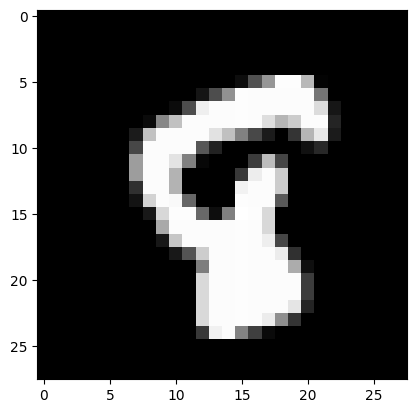

In [31]:
plt.imshow(bx[0].view(28,28))

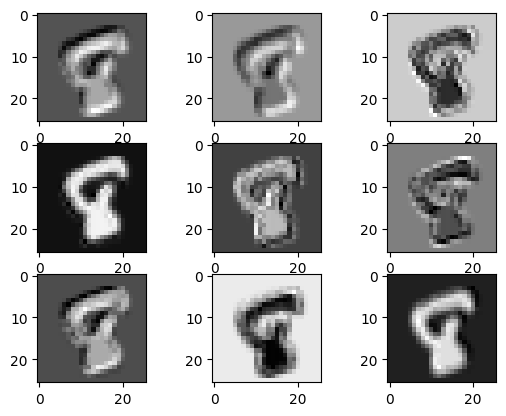

In [32]:
show_images(activation[0])

In [33]:
class CNN(nn.Module):
  def __init__(self, features):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=features, kernel_size=(3,3), stride=(1,1), padding='same')
    self.conv2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=(3,3), stride=(1,1), padding='same')
    self.activation_fn = nn.ReLU()
    self.fc = nn.Linear(28*28*features, 10)

  def forward(self, x):
    out1 = self.conv1(x)
    out2 = self.activation_fn(out1)
    out3 = self.conv2(out2)
    out4 = self.activation_fn(out3)
    out4 = out4.view(out3.shape[0], -1)
    out5 = self.fc(out4)
    return out5

In [34]:
features = 9
model = CNN(features)

In [105]:
def train_eval(model, optimizer, train_loader=train_loader, valid_loader=valid_loader, epoch=10, dims=3, im_shape = 28, n_channels=1, index=0, display_freq=10):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = model.to(device)
  plt.close('all')
  for e in range(epoch):
    correct = 0
    total = 0
    losses = []

    # training
    model.train()
    for bx, by in train_loader:
      if dims==3: bx = bx.view(-1, n_channels, im_shape, im_shape)
      bx, by = bx.to(device), by.to(device)
      output = model(bx)
      loss = loss_fn(output, by)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses.append(loss.detach().item())

    # validation
    model.eval()
    for bx, by in valid_loader:
      if dims==3: bx = bx.view(-1, n_channels, im_shape, im_shape)
      bx, by = bx.to(device), by.to(device)
      with torch.no_grad():
        output = model(bx)
      predictions = output.argmax(-1)

      correct += (predictions==by).float().sum()
      total += len(by)

    accuracy = correct/total

    print(f'epoch {e}; loss {np.mean(losses):.4f}; accuracy {accuracy:.2f}')

    img=bx[index]
    if e==0:
      fig, ax = plt.subplots(1,1)
      ax.imshow(bx[index].view(im_shape, im_shape, n_channels).cpu())
      ax.set_title(cifar_train.classes[by[index].cpu()])

    if e%display_freq==0:
      with torch.no_grad():
        first_conv_activation = model.conv1(img.view(n_channels, im_shape, im_shape))
        show_images(first_conv_activation.cpu(), title='layer 1')
        second_conv_activation = model.conv2(first_conv_activation)
        show_images(second_conv_activation.cpu(), title='layer 2')
        third_conv_activation = model.conv3(second_conv_activation)
        show_images(third_conv_activation.cpu(), title='layer 3')


      plt.pause(1)
    print('*'*20)

In [67]:
features = 9
lr = 0.001

model = CNN(features)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [68]:
train_eval(model, optimizer, dims=3)

RuntimeError: ignored

In [ ]:
index = 1
img = bx[index].view(1, 28, 28)
plt.imshow(img.squeeze())
img.shape

In [ ]:
by[1]

In [ ]:
first_conv_activation = model.conv1(img)
first_conv_activation.shape

In [ ]:
show_images(first_conv_activation)

In [ ]:
second_conv_activation = model.conv2(first_conv_activation)
second_conv_activation.shape

In [ ]:
show_images(second_conv_activation)

# Cifar-10

In [39]:
from torchvision import datasets

In [40]:
cifar_train = datasets.CIFAR10(root='./', train=True, download=True)
cifar_test = datasets.CIFAR10(root='./', train=False, download=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 12104325.69it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [41]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [42]:
x_train = tensor(cifar_train.data)
y_train = tensor(cifar_train.targets)
x_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [43]:
x_test = tensor(cifar_test.data)
y_test = tensor(cifar_test.targets)
x_test.shape, y_test.shape

(torch.Size([10000, 32, 32, 3]), torch.Size([10000]))

normalize

In [44]:
x_train = x_train/255.
x_test = x_test/255.
x_train.dtype

torch.float32

## Create dataset and dataloader

In [45]:
trainset = dataset(x_train, y_train)
testset = dataset(x_test, y_test)

In [46]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
valid_loader = DataLoader(testset, batch_size=64)

In [47]:
cifar_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([32, 32, 3])

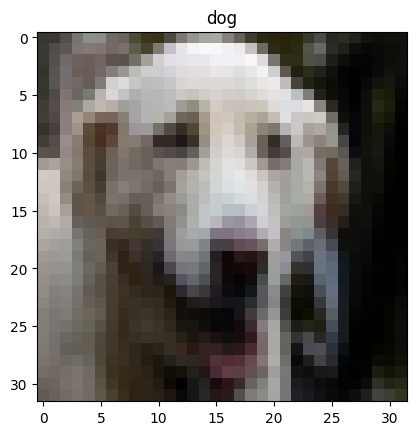

In [48]:
index = 0
bx, by = next(iter(train_loader))
plt.imshow(bx[index])
plt.title(cifar_train.classes[by[index]])
bx[index].shape

In [130]:
class CNN(nn.Module):
  def __init__(self, features):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=features, kernel_size=(3,3), stride=(1,1), padding='same')
    self.conv2 = nn.Conv2d(in_channels=features, out_channels=features*2, kernel_size=(3,3), stride=(1,1), padding='same')
    self.conv3 = nn.Conv2d(in_channels=features*2, out_channels=features*4, kernel_size=(3,3), stride=(1,1), padding='same')
    self.activation_fn = nn.ReLU()
    self.pooling = nn.MaxPool2d((2, 2))
    self.global_pooling = nn.AdaptiveAvgPool2d()
    self.fc = nn.Linear(features*4, 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.activation_fn(out)
    out = self.pooling(out)
    out = self.conv2(out)
    out = self.activation_fn(out)
    out = self.pooling(out)
    out = self.conv3(out)
    out = self.activation_fn(out)
    out = self.global_pooling(out)
    out = out.view(out.shape[0], -1)
    out = self.fc(out)
    return out

In [131]:
features = 8
lr = 0.001
epochs = 100

model = CNN(features)
optimizer = torch.optim.AdamW(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

TypeError: ignored

epoch 0; loss 1.2450; accuracy 0.49


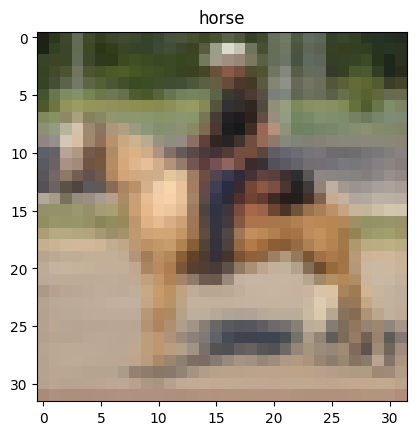

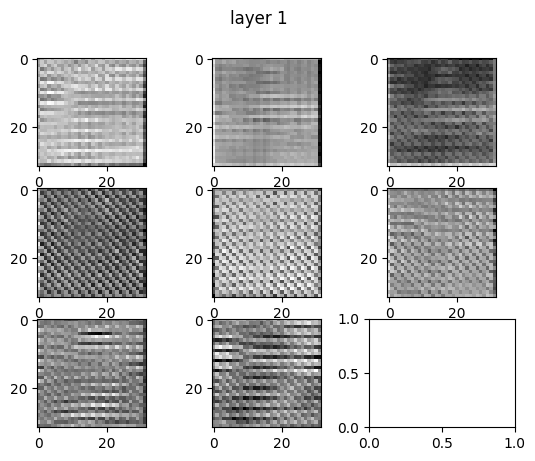

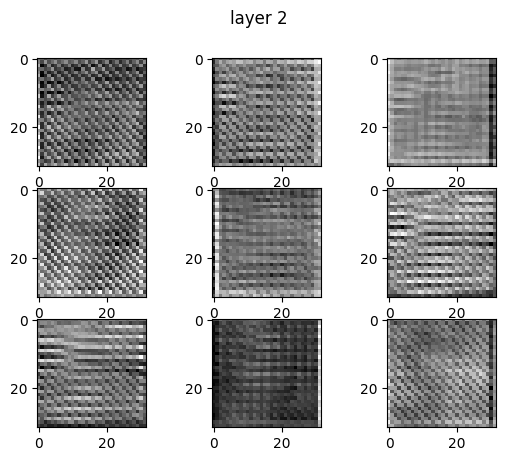

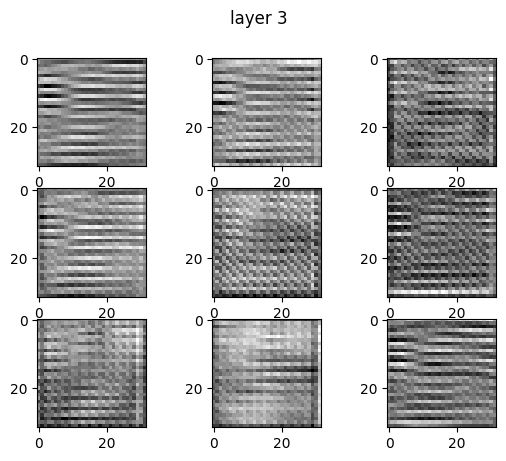

********************
epoch 1; loss 1.2443; accuracy 0.48
********************
epoch 2; loss 1.2408; accuracy 0.49
********************
epoch 3; loss 1.2400; accuracy 0.49
********************
epoch 4; loss 1.2362; accuracy 0.49
********************
epoch 5; loss 1.2355; accuracy 0.50
********************
epoch 6; loss 1.2315; accuracy 0.50
********************
epoch 7; loss 1.2293; accuracy 0.50
********************
epoch 8; loss 1.2254; accuracy 0.50
********************
epoch 9; loss 1.2242; accuracy 0.50
********************
epoch 10; loss 1.2188; accuracy 0.49


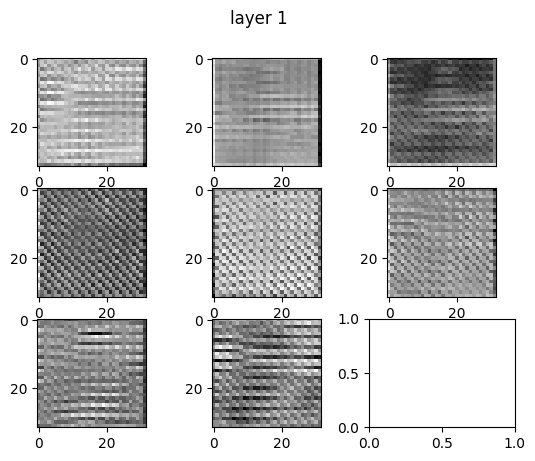

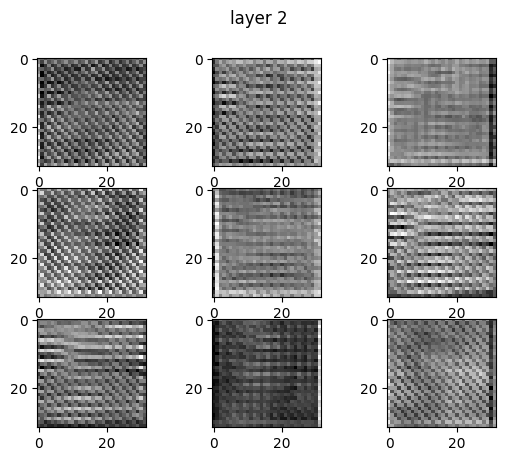

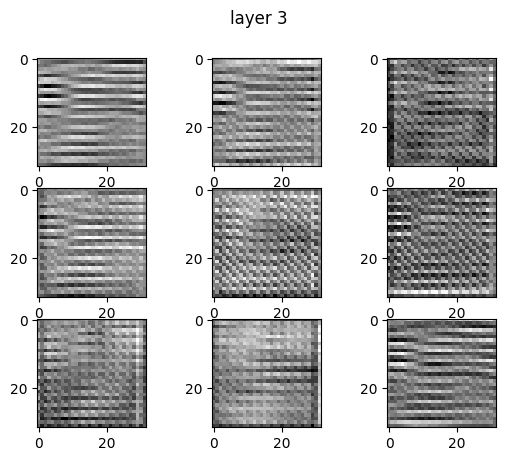

********************
epoch 11; loss 1.2236; accuracy 0.49
********************
epoch 12; loss 1.2185; accuracy 0.50
********************
epoch 13; loss 1.2158; accuracy 0.49
********************
epoch 14; loss 1.2105; accuracy 0.50
********************
epoch 15; loss 1.2142; accuracy 0.50
********************
epoch 16; loss 1.2112; accuracy 0.49
********************
epoch 17; loss 1.2078; accuracy 0.49
********************
epoch 18; loss 1.2036; accuracy 0.49
********************
epoch 19; loss 1.2043; accuracy 0.50
********************
epoch 20; loss 1.2057; accuracy 0.50


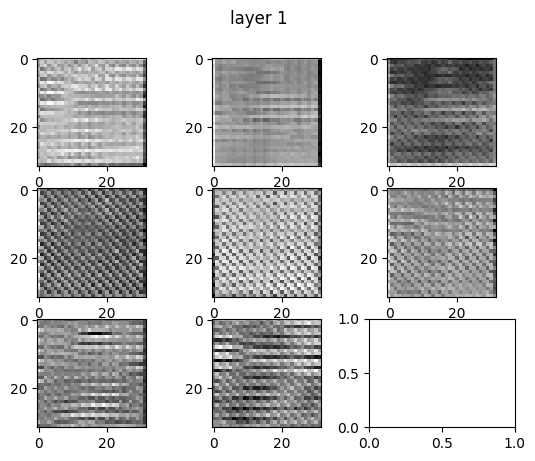

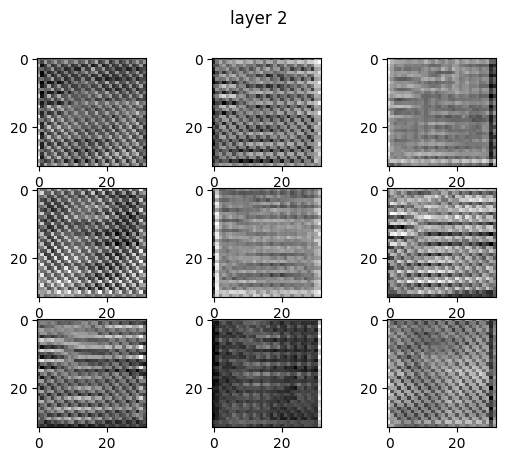

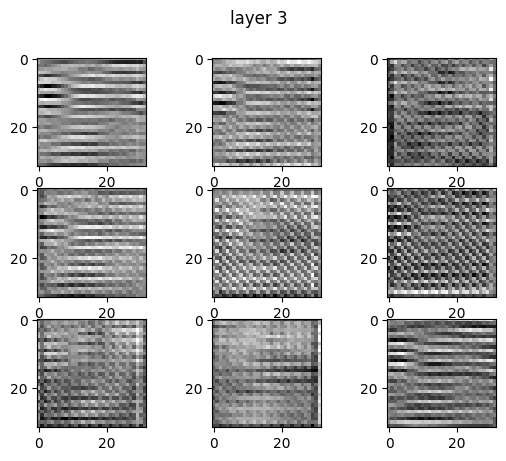

********************
epoch 21; loss 1.2014; accuracy 0.50
********************
epoch 22; loss 1.1988; accuracy 0.50
********************
epoch 23; loss 1.2005; accuracy 0.50
********************
epoch 24; loss 1.1956; accuracy 0.49
********************
epoch 25; loss 1.1943; accuracy 0.49
********************
epoch 26; loss 1.1931; accuracy 0.50
********************
epoch 27; loss 1.1945; accuracy 0.49
********************
epoch 28; loss 1.1922; accuracy 0.50
********************
epoch 29; loss 1.1891; accuracy 0.50
********************
epoch 30; loss 1.1911; accuracy 0.50


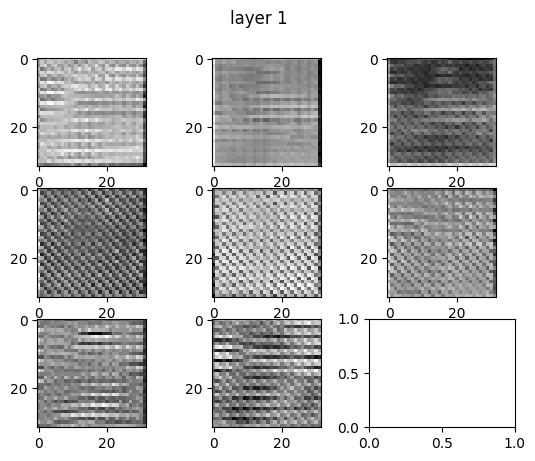

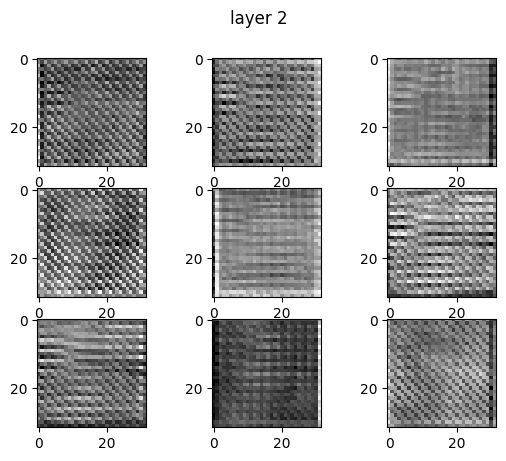

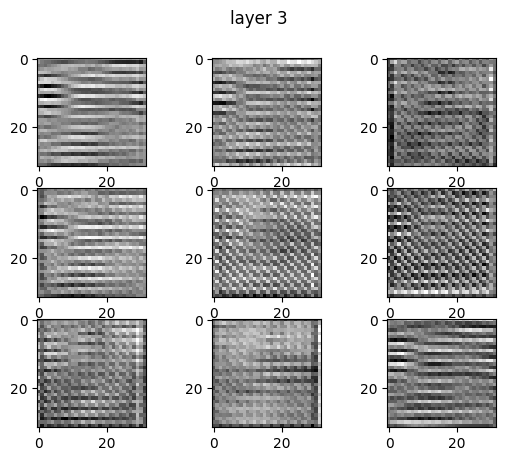

********************
epoch 31; loss 1.1864; accuracy 0.49
********************
epoch 32; loss 1.1842; accuracy 0.50
********************
epoch 33; loss 1.1858; accuracy 0.50
********************
epoch 34; loss 1.1837; accuracy 0.50
********************
epoch 35; loss 1.1837; accuracy 0.50
********************
epoch 36; loss 1.1831; accuracy 0.49
********************
epoch 37; loss 1.1818; accuracy 0.49
********************
epoch 38; loss 1.1815; accuracy 0.50
********************
epoch 39; loss 1.1793; accuracy 0.49
********************
epoch 40; loss 1.1748; accuracy 0.50


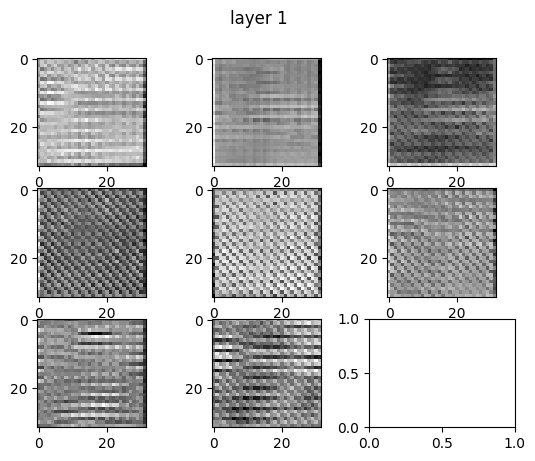

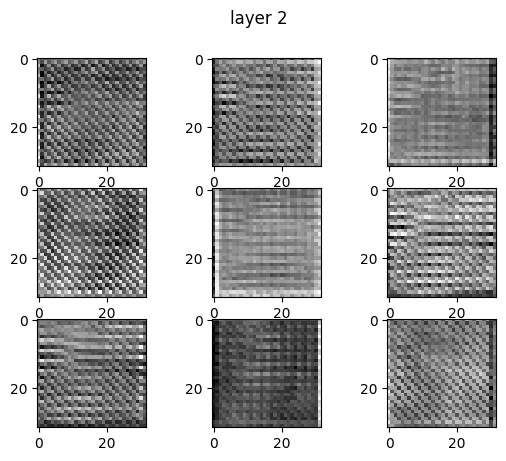

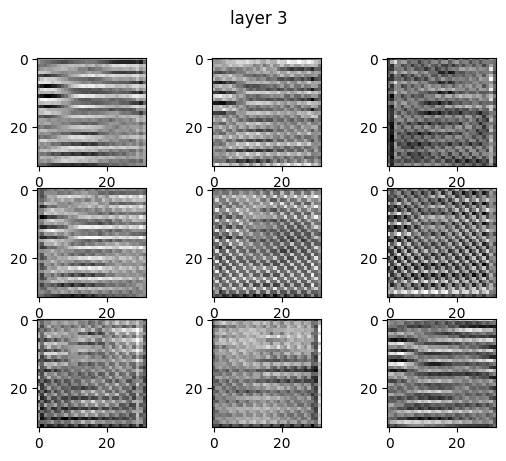

********************
epoch 41; loss 1.1751; accuracy 0.49
********************
epoch 42; loss 1.1773; accuracy 0.50
********************
epoch 43; loss 1.1748; accuracy 0.50
********************
epoch 44; loss 1.1737; accuracy 0.50
********************
epoch 45; loss 1.1706; accuracy 0.50
********************
epoch 46; loss 1.1731; accuracy 0.51
********************
epoch 47; loss 1.1669; accuracy 0.50
********************
epoch 48; loss 1.1720; accuracy 0.50
********************
epoch 49; loss 1.1657; accuracy 0.50
********************
epoch 50; loss 1.1687; accuracy 0.51


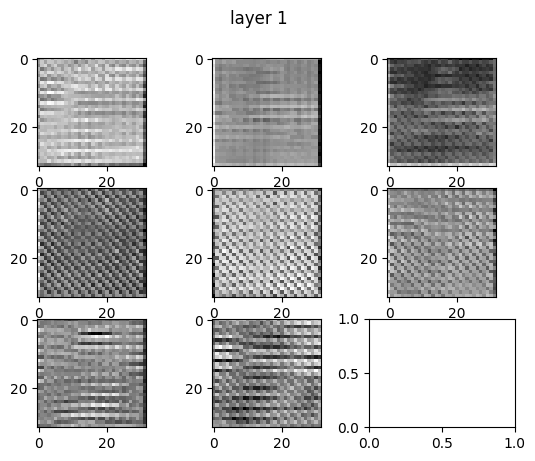

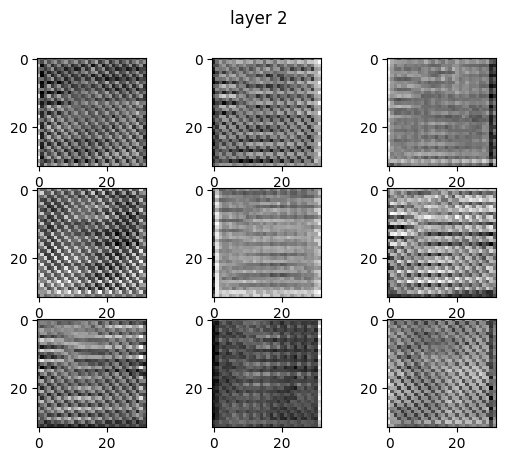

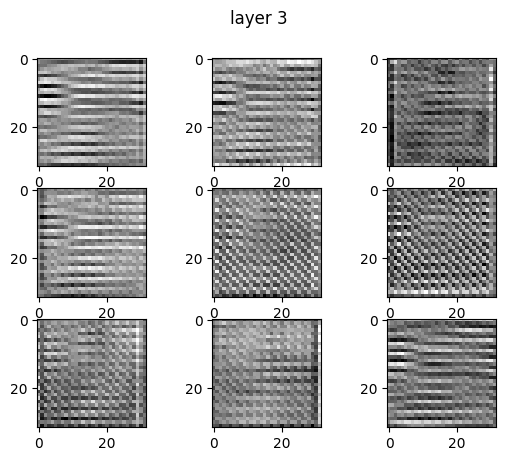

********************
epoch 51; loss 1.1663; accuracy 0.50
********************
epoch 52; loss 1.1666; accuracy 0.50
********************
epoch 53; loss 1.1655; accuracy 0.50
********************
epoch 54; loss 1.1634; accuracy 0.49
********************
epoch 55; loss 1.1648; accuracy 0.50
********************
epoch 56; loss 1.1619; accuracy 0.50
********************
epoch 57; loss 1.1613; accuracy 0.50
********************
epoch 58; loss 1.1614; accuracy 0.51
********************
epoch 59; loss 1.1615; accuracy 0.50
********************
epoch 60; loss 1.1541; accuracy 0.50


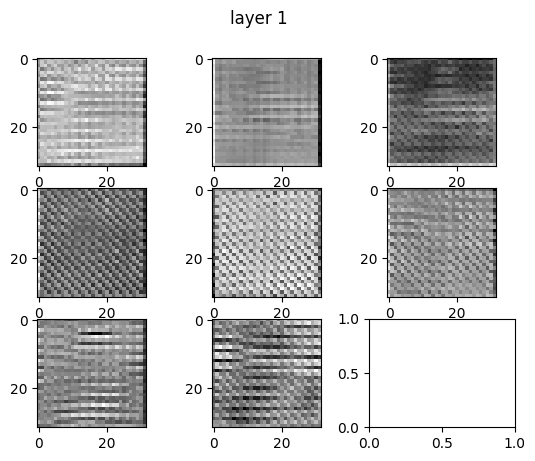

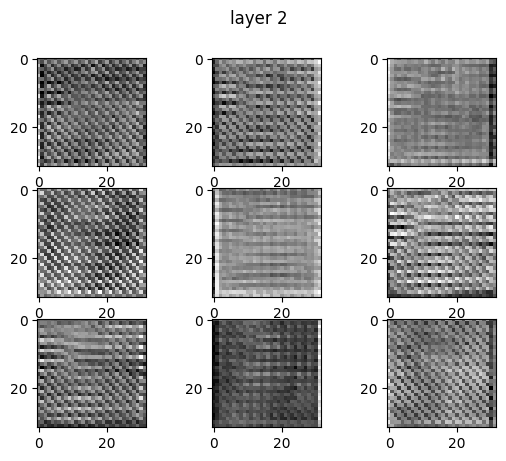

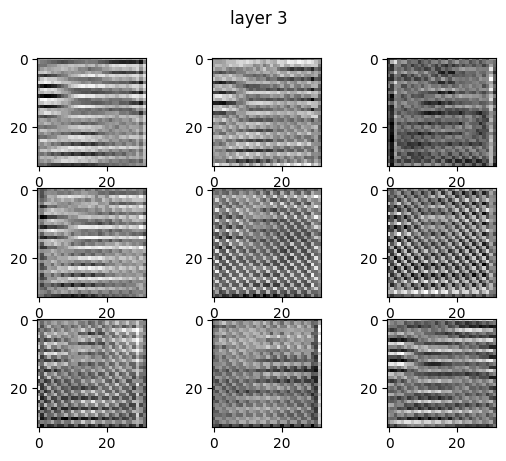

********************
epoch 61; loss 1.1559; accuracy 0.50
********************
epoch 62; loss 1.1574; accuracy 0.50
********************
epoch 63; loss 1.1555; accuracy 0.50
********************
epoch 64; loss 1.1575; accuracy 0.49
********************
epoch 65; loss 1.1580; accuracy 0.50
********************
epoch 66; loss 1.1594; accuracy 0.50
********************
epoch 67; loss 1.1529; accuracy 0.51
********************
epoch 68; loss 1.1565; accuracy 0.50
********************
epoch 69; loss 1.1536; accuracy 0.50
********************
epoch 70; loss 1.1511; accuracy 0.51


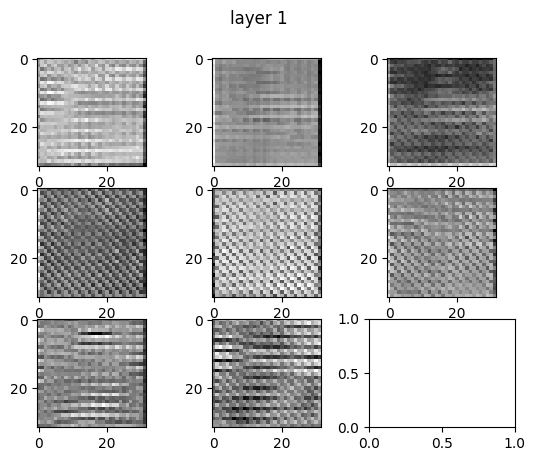

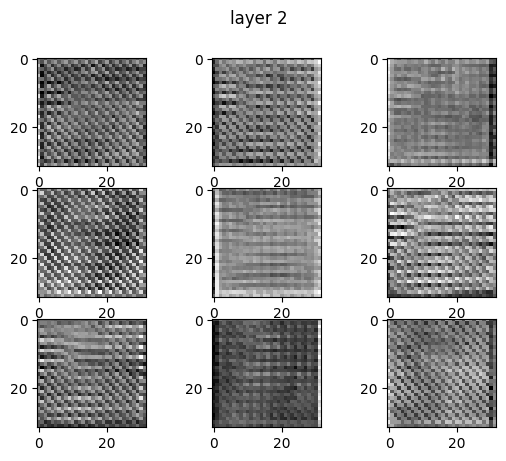

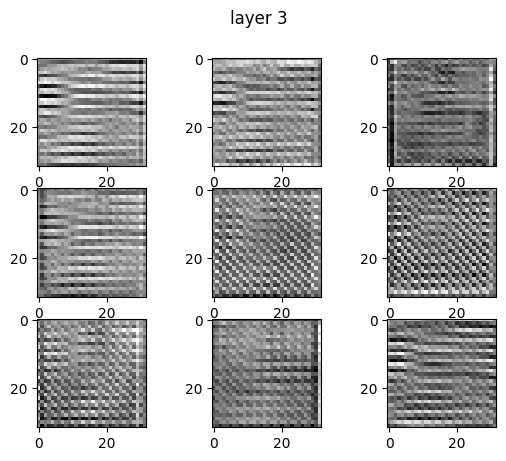

********************
epoch 71; loss 1.1517; accuracy 0.50
********************
epoch 72; loss 1.1473; accuracy 0.50
********************
epoch 73; loss 1.1529; accuracy 0.50
********************
epoch 74; loss 1.1502; accuracy 0.50
********************
epoch 75; loss 1.1526; accuracy 0.51
********************
epoch 76; loss 1.1487; accuracy 0.51
********************
epoch 77; loss 1.1517; accuracy 0.50
********************
epoch 78; loss 1.1458; accuracy 0.50
********************
epoch 79; loss 1.1505; accuracy 0.50
********************
epoch 80; loss 1.1497; accuracy 0.50


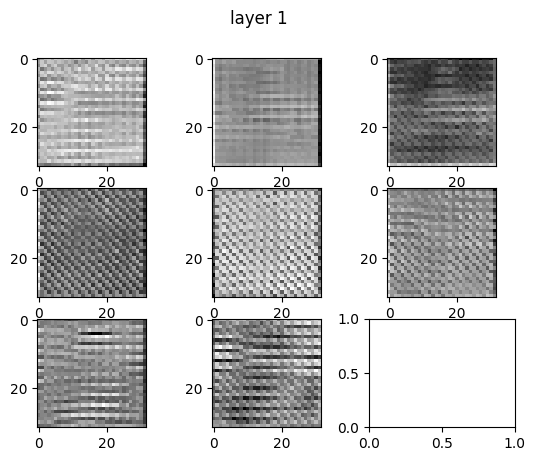

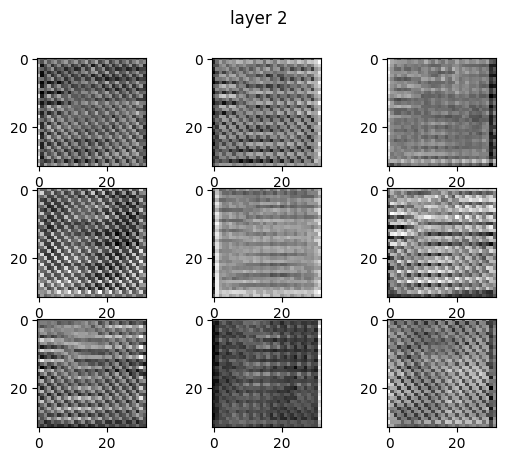

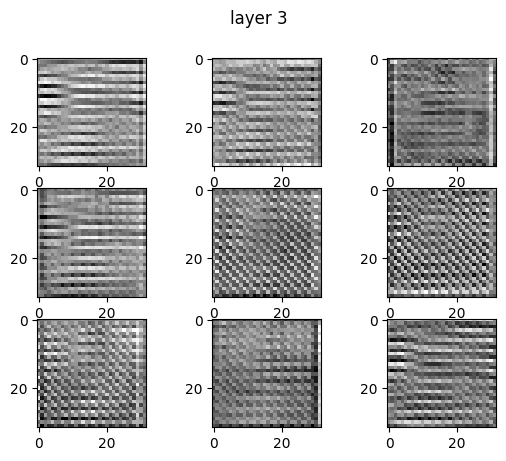

********************
epoch 81; loss 1.1479; accuracy 0.50
********************
epoch 82; loss 1.1457; accuracy 0.50
********************
epoch 83; loss 1.1487; accuracy 0.51
********************
epoch 84; loss 1.1455; accuracy 0.50
********************
epoch 85; loss 1.1448; accuracy 0.51
********************
epoch 86; loss 1.1437; accuracy 0.51
********************
epoch 87; loss 1.1436; accuracy 0.50
********************
epoch 88; loss 1.1425; accuracy 0.49
********************
epoch 89; loss 1.1411; accuracy 0.51
********************
epoch 90; loss 1.1440; accuracy 0.50


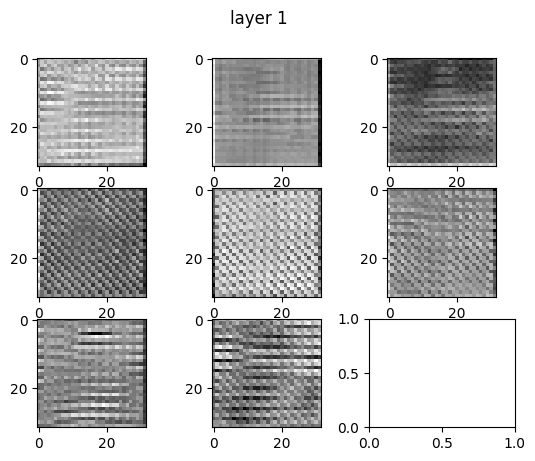

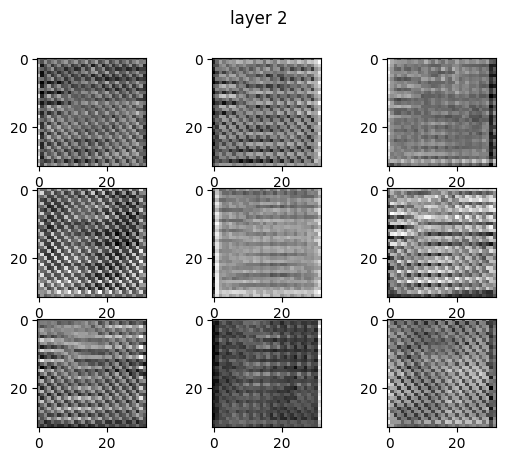

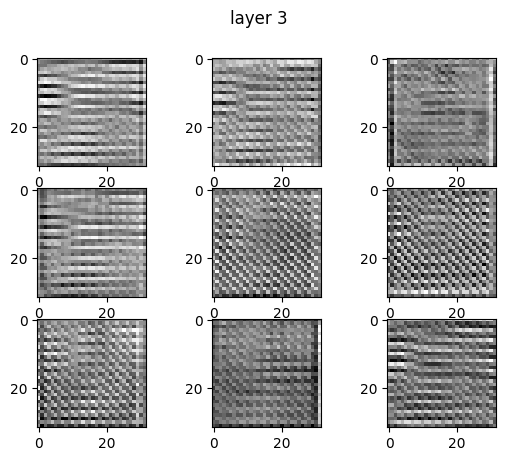

********************
epoch 91; loss 1.1404; accuracy 0.50
********************
epoch 92; loss 1.1421; accuracy 0.50
********************
epoch 93; loss 1.1427; accuracy 0.50
********************
epoch 94; loss 1.1384; accuracy 0.51
********************
epoch 95; loss 1.1390; accuracy 0.50
********************
epoch 96; loss 1.1395; accuracy 0.51
********************
epoch 97; loss 1.1397; accuracy 0.51
********************
epoch 98; loss 1.1410; accuracy 0.50
********************
epoch 99; loss 1.1402; accuracy 0.50
********************


In [132]:
train_eval(model, optimizer, train_loader, valid_loader, im_shape=32, n_channels=3, epoch=epochs, display_freq=10)

torch.Size([32, 32, 3])

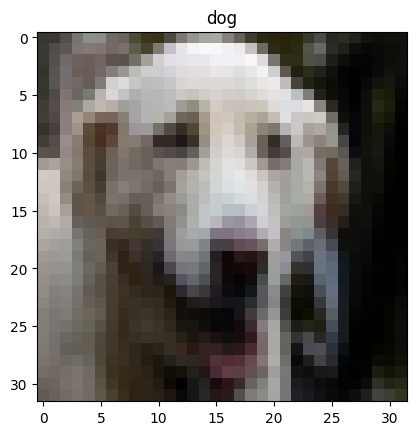

In [133]:
index = 0
img=bx[index]
plt.imshow(bx[index])
plt.title(cifar_train.classes[by[index]])
bx[index].shape

torch.Size([8, 32, 32])

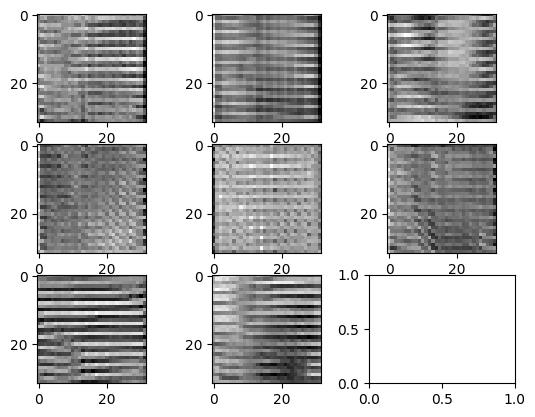

In [134]:
first_conv_activation = model.conv1(img.view(3, 32, 32).cuda())
show_images(first_conv_activation.cpu())
first_conv_activation.shape

torch.Size([16, 32, 32])

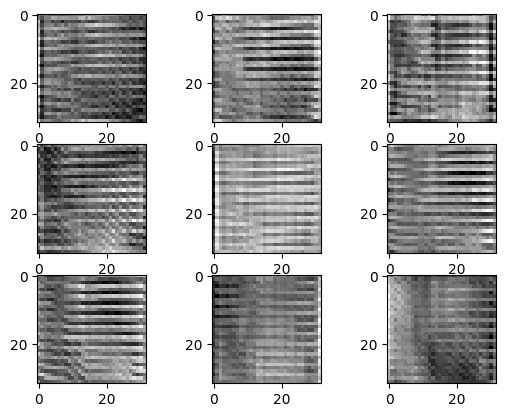

In [135]:
second_conv_activation = model.conv2(first_conv_activation.cuda())
show_images(second_conv_activation.cpu())
second_conv_activation.shape